In [1]:
import os, random, zipfile
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers

2025-06-24 00:55:04.356317: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750726504.528292      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750726504.577095      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
AUTOTUNE = tf.data.AUTOTUNE
IMG_SIZE = 256
BATCH_SIZE = 1
EPOCHS = 10

LIMIT_SIZE = 300

monet_dir = '/kaggle/input/gan-getting-started/monet_jpg'
photo_dir = '/kaggle/input/gan-getting-started/photo_jpg'

In [3]:
def show_samples(folder, title):
    files = os.listdir(folder)
    samples = random.sample(files, 5)
    plt.figure(figsize=(15,3))
    for i, f in enumerate(samples):
        img = Image.open(os.path.join(folder, f))
        plt.subplot(1,5,i+1)
        plt.imshow(img)
        plt.title(f"{title} {i+1}")
        plt.axis('off')
    plt.show()

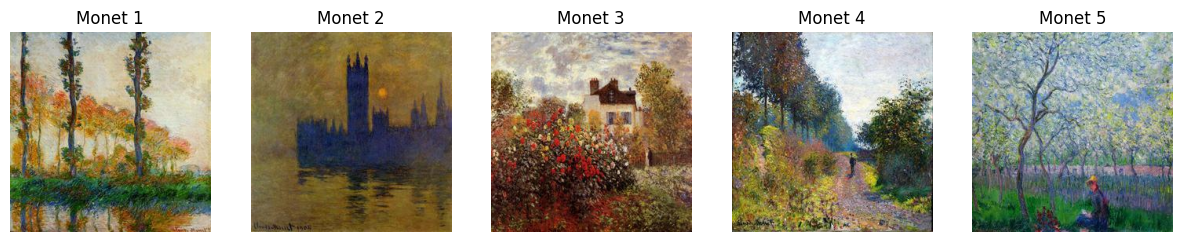

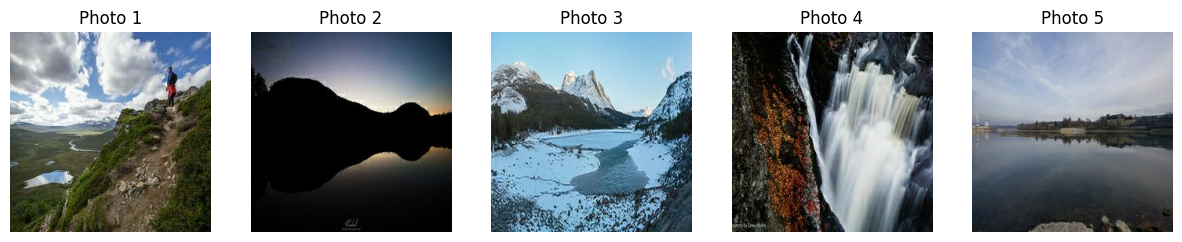

In [4]:
show_samples(monet_dir, "Monet")
show_samples(photo_dir, "Photo")

In [5]:
def load_image(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = (tf.cast(img, tf.float32) / 127.5) - 1
    return img

In [6]:
monet_files = tf.data.Dataset.list_files(monet_dir + '/*.jpg', shuffle=True)
photo_files = tf.data.Dataset.list_files(photo_dir + '/*.jpg', shuffle=True)

monet_ds = monet_files.take(LIMIT_SIZE).map(load_image, num_parallel_calls=AUTOTUNE)
photo_ds = photo_files.take(LIMIT_SIZE).map(load_image, num_parallel_calls=AUTOTUNE)

monet_ds = monet_ds.cache().shuffle(200).batch(BATCH_SIZE).prefetch(AUTOTUNE)
photo_ds = photo_ds.cache().shuffle(200).batch(BATCH_SIZE).prefetch(AUTOTUNE)

train_ds = tf.data.Dataset.zip((photo_ds, monet_ds)).prefetch(AUTOTUNE)

I0000 00:00:1750726518.643867      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [7]:
def build_generator():
    inputs = layers.Input(shape=[IMG_SIZE, IMG_SIZE, 3])
    
    x = layers.Conv2D(64, 7, padding='same')(inputs)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(128, 3, strides=2, padding='same')(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(256, 3, strides=2, padding='same')(x)
    x = layers.Activation('relu')(x)

    res = x
    x = layers.Conv2D(256, 3, padding='same')(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(256, 3, padding='same')(x)
    x = layers.add([x, res])

    x = layers.Conv2DTranspose(128, 3, strides=2, padding='same')(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2DTranspose(64, 3, strides=2, padding='same')(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(3, 7, padding='same')(x)
    outputs = layers.Activation('tanh')(x)

    return tf.keras.Model(inputs=inputs, outputs=outputs)


In [8]:
def build_discriminator():
    inp = layers.Input(shape=[IMG_SIZE, IMG_SIZE, 3])
    x = layers.Conv2D(64, 4, strides=2, padding='same')(inp)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2D(128, 4, strides=2, padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2D(256, 4, strides=2, padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2D(1, 4, padding='same')(x)
    return tf.keras.Model(inputs=inp, outputs=x)

In [9]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
    return (loss_obj(tf.ones_like(real), real) + loss_obj(tf.zeros_like(generated), generated)) * 0.5

def generator_loss(fake):
    return loss_obj(tf.ones_like(fake), fake)

def cycle_loss(real, cycled):
    return 10 * tf.reduce_mean(tf.abs(real - cycled))

def identity_loss(real, same):
    return 5 * tf.reduce_mean(tf.abs(real - same))

In [10]:
G = build_generator()
F = build_generator()
D_X = build_discriminator()
D_Y = build_discriminator()

G_opt = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
F_opt = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
D_X_opt = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
D_Y_opt = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [11]:
def train_step(real_x, real_y):
    with tf.GradientTape(persistent=True) as tape:
        fake_y = G(real_x, training=True)
        cycled_x = F(fake_y, training=True)

        fake_x = F(real_y, training=True)
        cycled_y = G(fake_x, training=True)

        same_x = F(real_x, training=True)
        same_y = G(real_y, training=True)

        disc_real_x = D_X(real_x, training=True)
        disc_real_y = D_Y(real_y, training=True)

        disc_fake_x = D_X(fake_x, training=True)
        disc_fake_y = D_Y(fake_y, training=True)

        G_loss = generator_loss(disc_fake_y)
        F_loss = generator_loss(disc_fake_x)
        cyc_loss = cycle_loss(real_x, cycled_x) + cycle_loss(real_y, cycled_y)
        id_loss = identity_loss(real_x, same_x) + identity_loss(real_y, same_y)

        total_G = G_loss + cyc_loss + id_loss
        total_F = F_loss + cyc_loss + id_loss
        DX_loss = discriminator_loss(disc_real_x, disc_fake_x)
        DY_loss = discriminator_loss(disc_real_y, disc_fake_y)

    G_opt.apply_gradients(zip(tape.gradient(total_G, G.trainable_variables), G.trainable_variables))
    F_opt.apply_gradients(zip(tape.gradient(total_F, F.trainable_variables), F.trainable_variables))
    D_X_opt.apply_gradients(zip(tape.gradient(DX_loss, D_X.trainable_variables), D_X.trainable_variables))
    D_Y_opt.apply_gradients(zip(tape.gradient(DY_loss, D_Y.trainable_variables), D_Y.trainable_variables))

In [12]:
with tf.device('/GPU:0'): 
    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch+1}/{EPOCHS}")
        for photo, monet in tqdm(train_ds, desc=f"Training Epoch {epoch+1}"):
            train_step(monet, photo)


Epoch 1/10


Training Epoch 1: 100%|██████████| 300/300 [02:49<00:00,  1.77it/s]



Epoch 2/10


Training Epoch 2: 100%|██████████| 300/300 [02:46<00:00,  1.80it/s]



Epoch 3/10


Training Epoch 3: 100%|██████████| 300/300 [02:46<00:00,  1.80it/s]



Epoch 4/10


Training Epoch 4: 100%|██████████| 300/300 [02:47<00:00,  1.80it/s]



Epoch 5/10


Training Epoch 5: 100%|██████████| 300/300 [02:45<00:00,  1.81it/s]



Epoch 6/10


Training Epoch 6: 100%|██████████| 300/300 [02:45<00:00,  1.81it/s]



Epoch 7/10


Training Epoch 7: 100%|██████████| 300/300 [02:45<00:00,  1.81it/s]



Epoch 8/10


Training Epoch 8: 100%|██████████| 300/300 [02:45<00:00,  1.81it/s]



Epoch 9/10


Training Epoch 9: 100%|██████████| 300/300 [02:45<00:00,  1.81it/s]



Epoch 10/10


Training Epoch 10: 100%|██████████| 300/300 [02:44<00:00,  1.82it/s]


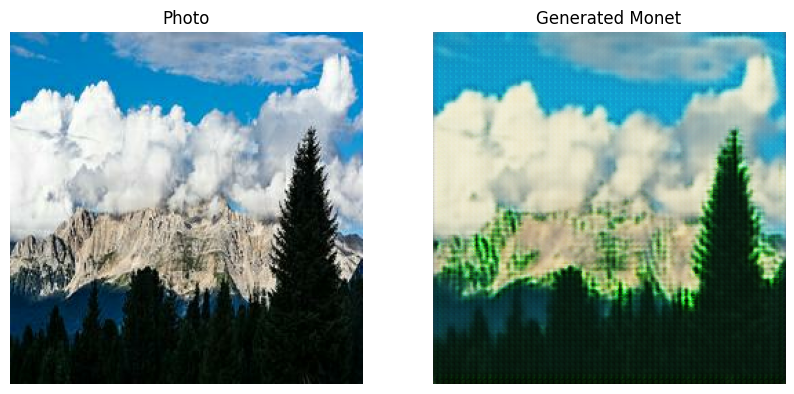

In [13]:
test_photo = next(iter(photo_ds))
monet_img = G(test_photo, training=False)[0]

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow((test_photo[0]+1)/2); plt.title("Photo"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow((monet_img+1)/2); plt.title("Generated Monet"); plt.axis("off")
plt.show()

In [14]:
EXPORT_COUNT = 7000  

os.makedirs("gen_images", exist_ok=True)

with zipfile.ZipFile("images.zip", "w") as zipf:
    for i in tqdm(range(EXPORT_COUNT), desc="Exporting Monet-style Images"):
        photo_batch = next(iter(photo_ds))
        generated = G(photo_batch, training=False)[0]
        img = ((generated + 1) * 127.5).numpy().astype('uint8')
        img = Image.fromarray(img)
        fname = f"gen_images/image_{i:05d}.jpg"
        img.save(fname)
        zipf.write(fname, os.path.basename(fname))
        os.remove(fname)

Exporting Monet-style Images: 100%|██████████| 7000/7000 [02:11<00:00, 53.17it/s]
